In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.helper import npa_to_seq
import timeit


from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery
table_redmapper_halos = fits.open("catalogs/redmapper_halos.fits")[1].data
Ncm.cfg_init()
#%matplotlib inline

In [2]:
pz_min = 0.1
pz_max = 1.1
logRmin = 0
logRmax = 3 

# We are loading the cosmoDC2_redmapper catalalog with richness
redmapper_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_redmapper_v0.8.1")

# Taking some important information about the fiducial cosmological model and survey region
redmapper_cosmology = redmapper_cat.cosmology
sky_area = redmapper_cat.sky_area
# Listing all quantities in the choosen catalog
#np.sort(redmapper_cat.list_all_quantities())
#print(np.sort(redmapper_cat.list_all_quantities()))
logRmin = 0
logRmax = 3 


#image_cat['halo_mass'].size()

data_redmapper = redmapper_cat.get_quantities(
    ["cluster_id", "redshift", "redshift_err", "richness", "richness_err", "ra", "dec"],
    filters=[
        f"redshift > {pz_min}",
        f"redshift < {pz_max}",
        f"richness > {10**logRmin}",
        f"richness < {10**logRmax}",
    ],
)
'''
table_redmapper_halos = fits.open("catalogs/redmapper_matched.fits")[1].data
data_redmapper = table_redmapper_halos
data_redmapper = Table(data_redmapper)
data_redmapper.rename_column('R', 'richness')
data_redmapper.rename_column('z', 'redshift')
data_redmapper.rename_column('z_err', 'redshift_err')
data_redmapper.rename_column('RA', 'ra')
data_redmapper.rename_column('DEC', 'dec')
'''

print("ra interval")
print(data_redmapper['ra'].min())
print(data_redmapper['ra'].max())
print('\n')

print("dec interval")
print(data_redmapper['dec'].min())
print(data_redmapper['dec'].max())
print('\n')

print("z interval")
print(data_redmapper['redshift'].min())
print(data_redmapper['redshift'].max())
print('\n')

print("richness interval")
print(data_redmapper['richness'].min())
print(data_redmapper['richness'].max())
print('\n')

print("sky_area = %.3f sqd" % (sky_area))
print(sky_area * (np.pi / 180) ** 2)
data_redmapper = Table(data_redmapper)
data_redmapper['richness'] = np.log(data_redmapper['richness'])


cut = data_redmapper['richness'].min()
lnR_max = np.log(200)

ra interval
47.83447574575201
75.9017151136021


dec interval
-46.51396804274271
-24.68019523136432


z interval
0.100568734
1.0998727


richness interval
5.007845
266.29504


sky_area = 439.790 sqd
0.13396765544773198


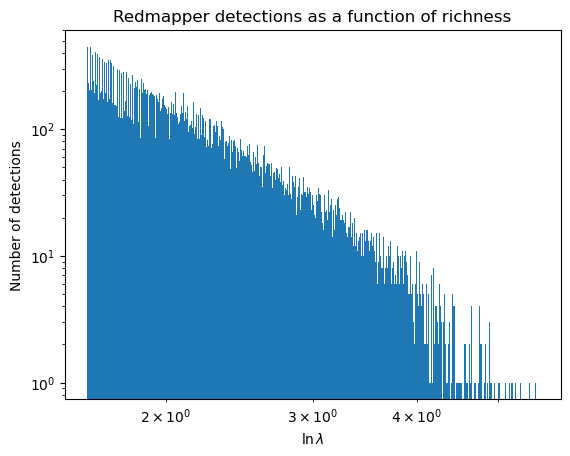

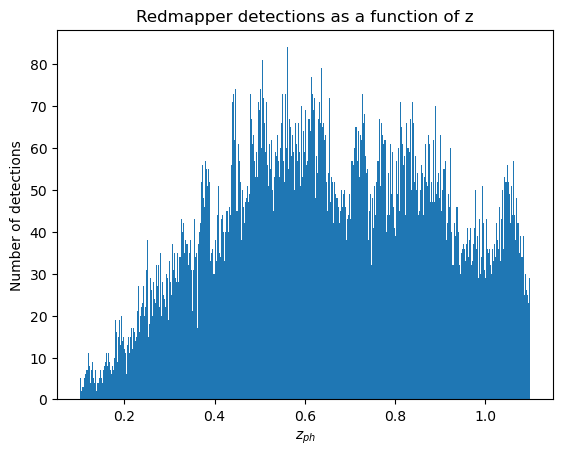

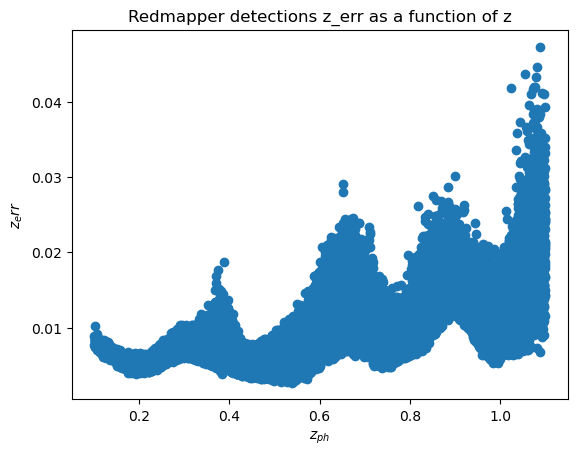

In [3]:
plt.hist(data_redmapper['richness'],bins=1000)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.show()

plt.hist(data_redmapper['redshift'],bins=1000)
plt.title("Redmapper detections as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.show()


plt.scatter(data_redmapper['redshift'], data_redmapper['redshift_err'])
plt.title("Redmapper detections z_err as a function of z")
plt.ylabel(r"$z_e{rr}$")
plt.xlabel(r"$z_{ph}$")
plt.show()

# Completeness Model

In [4]:
lnM_bins_knots = np.linspace(11.9 * np.log(10), 15 * np.log(10) ,10)
#lnM_bins_knots = np.linspace(13 * np.log(10), 16 * np.log(10) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnM_centers = 0.5 * (lnM_bins_knots[:-1] + lnM_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

completeness_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))

#mass 13.0 and s=1
completeness_smooth_clipped = np.array([[0.00775574, 0.0257542, 0.03300902, 0.03199418, 0.02518367, 0.01505147, 0.00407155, 0.0, 0.0],
    [0.25260502, 0.27061681, 0.27605795, 0.2718841, 0.26105089, 0.24651397, 0.23122899, 0.21336439, 0.21044216],
    [0.40262404, 0.43122535, 0.4456371, 0.44914992, 0.44505445, 0.43664132, 0.42720117, 0.41831353, 0.42562491],
    [0.50266196, 0.54495916, 0.57169553, 0.58647906, 0.59291775, 0.59461957, 0.59519252, 0.60182781, 0.62621808],
    [0.59756795, 0.64919758, 0.68418232, 0.70655894, 0.72036417, 0.72963479, 0.73840753, 0.75946354, 0.80210609],
    [0.73219118, 0.78131995, 0.81304655, 0.83207695, 0.84311712, 0.85087303, 0.86005064, 0.88677706, 0.94317338],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0]])

#mass 11.9 and s=0.01
completeness_smooth_clipped = np.array([[0.00119422126, 0.00281493621, 0.00300747736, 0.00228161573, 0.00218630487, 0.00190457050, 0.00128858137, 0.00135798388, 0.000823192247],
 [0.00257248346, 0.00428586091, 0.00685292638, 0.00443412452, 0.00484914622, 0.00418188519, 0.00246400910, 0.00255414149, 0.00135943029],
 [0.00618975878, 0.0100523280, 0.0141343696, 0.0121077444, 0.0118949221, 0.0111484982, 0.00703048140, 0.00646028836, 0.00480680526],
 [0.0369924839, 0.0418512744, 0.0472842241, 0.0496313367, 0.0479783727, 0.0331788502, 0.0223094701, 0.0170701668, 0.0105233141],
 [0.144478892, 0.148452493, 0.157501135, 0.172913874, 0.180015395, 0.135133711, 0.122016379, 0.100503054, 0.101546068],
 [0.346975669, 0.401193069, 0.405397060, 0.440418247, 0.442804044, 0.398720088, 0.427402052, 0.382703798, 0.444831860],
 [0.573356732, 0.585746894, 0.641882643, 0.669521128, 0.624506136, 0.606200115, 0.700544251, 0.597697307, 0.669063143],
 [0.610688067, 0.639754153, 0.629681103, 0.693391439, 0.674377330, 0.699885494, 0.797381682, 0.748818824, 0.740584334],
 [0.626335943, 0.792435821, 0.658813712, 0.943957277, 0.804286888, 0.709967027, 0.800181480, 0.833691572, 0.999913635]])

for i in range(len(z_centers)):
    for j in range(len(lnM_centers)):
        completeness_knots.set(i,j, completeness_smooth_clipped.T[i][j])

completeness = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=completeness_knots
)
completeness.prepare()
completeness.eval(33.387483848413666, 0.15000000000000002)

0.6097084002276337

# Purity Model

In [5]:
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))
z_bins_knots = np.array([0.1, 0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

purity_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
#mass 13
purity_smooth_clipped = np.array([[1/0.56847321, 1/0.56553304, 1/0.56643402, 1/0.57076391, 1/0.57811045, 1/0.58806141,
  1/0.60020452, 1/0.6216277,  1/0.64566435],
 [1/0.67394648, 1/0.63268226, 1/0.61286432, 1/0.61046677, 1/0.62146372, 1/0.64182928,
  1/0.66753754, 1/0.70731085, 1/0.7364596 ],
 [1/0.70418518, 1/0.67834512, 1/0.66613058, 1/0.66496127, 1/0.67225691, 1/0.6854372,
  1/0.70192186, 1/0.72720015, 1/0.74539913],
 [1/0.71291281, 1/0.72903127, 1/0.73877806, 1/0.74339086, 1/0.7441073,  1/0.74216506,
  1/0.73880177, 1/0.73379976, 1/0.73256222],
 [1/0.69006831, 1/0.77528975, 1/0.82370733, 1/0.84235979, 1/0.83828587, 1/0.81852433,
  1/0.79011389, 1/0.74667884, 1/0.72337672],
 [1/0.66000857, 1/0.76869821, 1/0.83518768, 1/0.86739902, 1/0.87325424, 1/0.86067539,
  1/0.8375845,  1/0.80056751, 1/0.78445986],
 [1/0.64127851, 1/0.70230658, 1/0.75435678, 1/0.7986071,  1/0.83623552, 1/0.86842004,
  1/0.89633865, 1/0.93279484, 1/0.96627892]])

#mass 11.9
purity_smooth_clipped = np.array([[1.443, 1.335, 1.244, 1.241, 1.182, 1.138, 1.145, 1.148, 1.088],
 [1.346, 1.361, 1.190, 1.222, 1.217, 1.171, 1.157, 1.137, 1.125],
 [1.410, 1.367, 1.180, 1.200, 1.251, 1.188, 1.116, 1.132, 1.081],
 [1.384, 1.325, 1.213, 1.183, 1.227, 1.202, 1.094, 1.126, 1.101],
 [1.246, 1.095, 1.188, 1.124, 1.149, 1.162, 1.119, 1.068, 1.114],
 [1.482, 1.088, 1.137, 1.043, 1.072, 1.069, 1.148, 1.068, 1.075],
 [1.504, 1.198, 1.005, 1.000, 1.104, 1.254, 1.175, 1.000, 1.000]])

for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        purity_knots.set(i,j, purity_smooth_clipped.T[i][j])

purity = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=purity_knots
)
purity.prepare()

purity.integ_dxdy(np.log(5), np.log(200), 0.1, 1.1)

4.314152047464849

# Cosmological Model

In [6]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.00)
#cosmo.param_set_by_name("Omegax", redmapper_cosmology.Ode0)
cosmo.param_set_by_name("H0", redmapper_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", redmapper_cosmology.Ob0)

cosmo.param_set_desc("Omegac",{ "lower-bound": 0.1,"upper-bound": 0.3,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": redmapper_cosmology.Odm0,})
cosmo.param_set_desc("w",{"lower-bound": -2.0,"upper-bound": -0.1,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -1.0,})

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA = redmapper_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
ln10e10ASA = np.log((redmapper_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude)

prim.param_set_desc("ln10e10ASA", {"lower-bound": 2.0,"upper-bound": 5.0,"scale": 1.0,"abstol": 1.0e-50,"fit": True,"value":  3.059917486993207,})
print(redmapper_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)


dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

0.7763884572510941
0.8 0.7999999999999999 3.059917486993207


# Cluster Mass-Richness and photoz model 

In [7]:
cut = np.log(5)
cluster_m = Nc.ClusterMassSelection(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m.param_set_by_name("mup0", 4.12769558168741)
cluster_m.param_set_by_name("mup1", 1.17476066603899)
cluster_m.param_set_by_name("mup2", 0.393577193825473 )
cluster_m.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m.param_set_by_name("sigmap2", -0.0644996574273048 )
cluster_m.set_lnM_limits(Ncm.Vector.new_array(npa_to_seq([np.log(10)* 12, np.log(10)* 16])))
#cluster_m.set_lnM_limits(Ncm.Vector.new_array(npa_to_seq([np.log(10)* 13.0, np.log(10)* 16])))
cluster_m.set_ipurity(purity)
cluster_m.set_completeness(completeness)
      
'''
cut = np.log(5)
cluster_m_ascaso = Nc.ClusterMassAscaso(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m_ascaso.param_set_by_name("mup0", 4.12769558168741)
cluster_m_ascaso.param_set_by_name("mup1", 1.17476066603899)
cluster_m_ascaso.param_set_by_name("mup2", 0.393577193825473 )
cluster_m_ascaso.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m_ascaso.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m_ascaso.param_set_by_name("sigmap2", -0.0644996574273048 )
 '''                       


cluster_m.param_set_by_name("cut", cut)
print(cluster_m.n_limits(cosmo)/np.log(10))
print(cluster_m.p_limits(cosmo, [cut] , [0])/np.log(10))
print(cluster_m.p_bin_limits(cosmo, [cut] , [0], [1])/np.log(10))

'''
cluster_m.set_property("mup0_fit", True)
cluster_m.set_property("mup1_fit", True)
cluster_m.set_property("mup2_fit", True)
cluster_m.set_property("sigmap0_fit", True)
cluster_m.set_property("sigmap1_fit", True)
cluster_m.set_property("sigmap2_fit", True)
'''

[12. 16.]
[12. 16.]
[12. 16.]


'\ncluster_m.set_property("mup0_fit", True)\ncluster_m.set_property("mup1_fit", True)\ncluster_m.set_property("mup2_fit", True)\ncluster_m.set_property("sigmap0_fit", True)\ncluster_m.set_property("sigmap1_fit", True)\ncluster_m.set_property("sigmap2_fit", True)\n'

In [8]:
cluster_z = Nc.ClusterPhotozGaussGlobal(pz_min = z_bins_knots[0],pz_max = z_bins_knots[-1])
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
z_bin = [(z_bins_knots[i] +z_bins_knots[i+1])/2 for i in range(len(z_bins_knots)-1)]

sigma2_SN        = np.array([])
sigma_intrinsic = np.array([])
for i in range(len(z_bins_knots)-1):
    data_bin = data_redmapper[(data_redmapper['redshift'] >= z_bins_knots[i]) & (data_redmapper['redshift']< z_bins_knots[i+1])]
    sigma2_SN = np.append(sigma2_SN, np.sum([(data_bin['redshift'][j] - z_bin[i])**2/len(data_bin['redshift'])**2 for j in range(len(data_bin['redshift']))]))
    sigma_intrinsic = np.append(sigma_intrinsic, 1/(np.sum([1/data_bin['redshift_err'][j]**2 for j in range(len(data_bin['redshift_err'])) ])))
    
sigma2_intrinsic = sigma_intrinsic**2
sigma = np.sqrt(sigma2_SN + sigma2_intrinsic) 

photoz_err = Ncm.Matrix.new(len(sigma), 2)
photoz_err.set_zero()
photoz_err.set_col(1, Ncm.Vector.new_array(npa_to_seq(sigma)))

photoz_err.log_vals("photoz_err:" , "%.10f")
print(sigma2_intrinsic)
print(sigma2_SN)
cluster_z = Nc.ClusterRedshiftNodist(z_min = z_bins_knots[0],z_max = z_bins_knots[-1])

photoz_err: 0.0000000000 0.0010949715
photoz_err: 0.0000000000 0.0005788948
photoz_err: [1.53378384e-15 3.11894600e-16 2.70299578e-16 3.27284196e-17
 5.98730911e-17 6.65064518e-16 1.98117972e-16 2.48581993e-16
 2.29801423e-15]
[1.19896248e-06 3.35119232e-07 2.22310594e-07 1.62012856e-07
 1.39575525e-07 1.47579274e-07 1.57586892e-07 3.37915234e-07
 1.74085543e-07]
0.0000000000 0.0004714982
photoz_err: 0.0000000000 0.0004025082
photoz_err: 0.0000000000 0.0003735981
photoz_err: 0.0000000000 0.0003841605
photoz_err: 0.0000000000 0.0003969722
photoz_err: 0.0000000000 0.0005813048
photoz_err: 0.0000000000 0.0004172356


# Cluster abundance model

42030.35673948041
42030.35673948041
42761


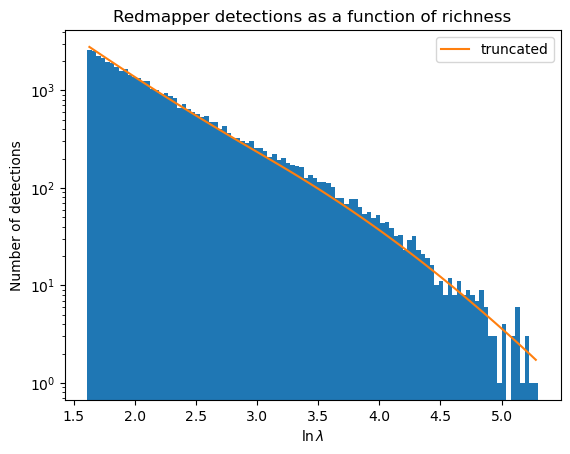

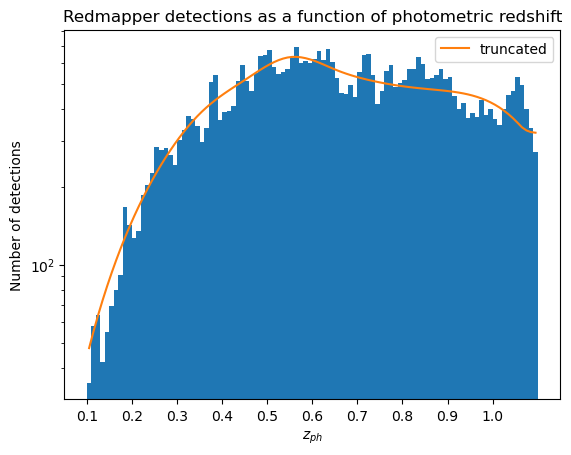

In [9]:
mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
#mulf.set_Delta(200.0)

# Discutivel
mulf_tinker = Nc.MultiplicityFuncTinker.new()
mulf_tinker.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf_tinker.set_Delta(200.0)
hmf_tinker = Nc.HaloMassFunction.new(dist, psf, mulf_tinker)
hmf_tinker.prepare(cosmo)
hmf_tinker.set_area(sky_area * (np.pi / 180) ** 2)
hbias_tinker = Nc.HaloBiasTinker.new(hmf_tinker)


hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hbias = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf,hbias)
cad.set_area(sky_area * (np.pi / 180) ** 2)



cad.prepare(cosmo , cluster_z , cluster_m)
print(cad.n(cosmo ,cluster_z , cluster_m))
print(cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [cut] , [lnR_max], None, [pz_min] , [pz_max] , [0.00,0.03]))
red_mapper_20 = data_redmapper[(data_redmapper['richness']>= cut) & (data_redmapper['richness'] < lnR_max) & (data_redmapper['redshift'] >= pz_min) & (data_redmapper['redshift'] < pz_max)]
print(len(red_mapper_20['richness']))



nbins=100
lnM_obs = np.linspace(cut, np.log(200) , nbins +1)
lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
z_obs = np.linspace(z_bins_knots[0], z_bins_knots[-1] , nbins +1)
z_obs_bin = [(z_obs[i] +z_obs[i+1])/2 for i in range(len(z_obs)-1)]
abundance_lnM = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03])  for i in range(len(lnM_obs)-1)]
#abundance_lnM_ascaso = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m_ascaso, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03])  for i in range(len(lnM_obs)-1)]
abundance_z = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [cut] , [lnR_max], None, [z_obs[i]] , [z_obs[i+1]] , [0.00,0.03 * (1 + z_obs_bin[i])])  for i in range(len(z_obs)-1)]
#abundance_z_ascaso = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m_ascaso, [cut] , [lnR_max], None, [z_obs[i]] , [z_obs[i+1]] , [0.00,0.03 * (1 + z_obs_bin[i])])  for i in range(len(z_obs)-1)]
#abundance_bias = [cad.intp_bin_d2n_bias(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03])  for i in range(len(lnM_obs)-1)]


plt.hist(red_mapper_20['richness'],bins=lnM_obs)
plt.plot(lnM_obs_bin,abundance_lnM,label="truncated")
#plt.plot(lnM_obs_bin,abundance_lnM_ascaso,label="ascaso")
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.legend()
plt.savefig("detections_R.png")
plt.show()

plt.hist(red_mapper_20['redshift'],bins=z_obs)
plt.plot(z_obs_bin,abundance_z,label="truncated")
#plt.plot(z_obs_bin,abundance_z_ascaso,label="ascaso")
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.xticks(np.arange(0.1, 1.1, step=0.1))
plt.title("Redmapper detections as a function of photometric redshift")
plt.savefig("detections_z.png")
plt.legend()
plt.show()

'''
plt.hist(red_mapper_20['richness'],bins=lnM_obs)
plt.plot(lnM_obs_bin,abundance_bias)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Bias of detections")
plt.xlabel(r"$\ln \lambda$")
plt.show()
'''
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

# Cluster counts binned likelihood

## S matrix 

In [10]:
kernel_z = np.linspace(0.0, 1.9, num=400 + 1)[1:]
kernels_T = np.zeros((len(z_bins_knots)-1, 400))
for i, (zminbin, zmaxbin) in enumerate(zip(z_bins_knots[:-1], z_bins_knots[1:])):
        Dz = zmaxbin - zminbin

        kernel = np.zeros_like(kernel_z)
        kernel[(kernel_z >= zminbin) & (kernel_z <= zmaxbin)] = 1.0
        kernels_T[i] = kernel / Dz
    
S_fullsky_array = PySSC.Sij(kernel_z, kernels_T, cosmo)
S_fullsky = Ncm.Matrix.new_array(S_fullsky_array.flatten(), S_fullsky_array.shape[1])

mean: 574.0000000000 129.0000000000 28.0000000000 42.0000000000 21.0000000000 6.0000000000 3.0000000000 1574.0000000000 312.0000000000 109.0000000000 142.0000000000 73.0000000000 14.0000000000 6.0000000000 2626.0000000000 549.0000000000 212.0000000000 255.0000000000 104.0000000000 13.0000000000 6.0000000000 3626.0000000000 750.0000000000 264.0000000000 305.0000000000 137.0000000000 17.0000000000 17.0000000000 4326.0000000000 887.0000000000 337.0000000000 362.0000000000 122.0000000000 19.0000000000 12.0000000000 3776.0000000000 880.0000000000 349.0000000000 377.0000000000 153.0000000000 31.0000000000 14.0000000000 3735.0000000000 860.0000000000 348.0000000000 312.0000000000 139.0000000000 21.0000000000 7.0000000000 6526.0000000000 1522.0000000000 667.0000000000 653.0000000000 288.0000000000 32.0000000000 22.0000000000 2775.0000000000 677.0000000000 254.0000000000 243.0000000000 102.0000000000 14.0000000000 5.0000000000
cov 0.0000000000 0.0000000000 0.0000000000 0.0000000000 4.2334785461

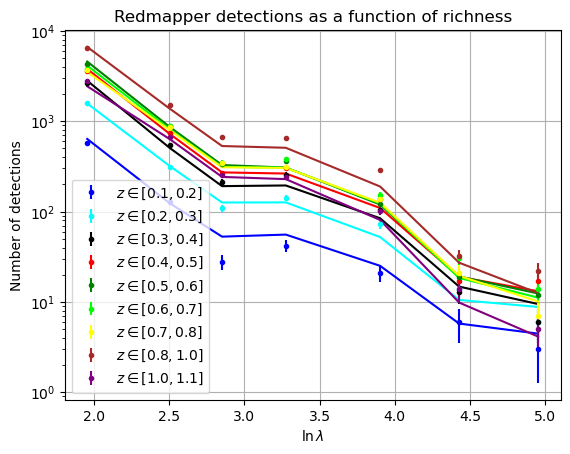

In [11]:
bin_counts = []
bin_counts_pure_complete = []
z_bins = [(z_bins_knots[j] + z_bins_knots[j+1])/2 for j in range(len(z_bins_knots)-1)]
lnR_bins = [(lnR_bins_knots[j] + lnR_bins_knots[j+1])/2 for j in range(len(lnR_bins_knots)-1)]
for i in range(len(z_bins_knots)-1):
    bins_coutns_z_i = red_mapper_20[(red_mapper_20['redshift'] >= z_bins_knots[i]) * (red_mapper_20['redshift'] < z_bins_knots[i+1])]

    for j in range(len(lnR_bins_knots)-1):
        bin_counts.append(len(bins_coutns_z_i[(bins_coutns_z_i['richness'] >= lnR_bins_knots[j]) * (bins_coutns_z_i['richness'] < lnR_bins_knots[j+1]
                                                                                                  )]))

z_bins_vec = Ncm.Vector.new_array(npa_to_seq(z_bins_knots))
lnR_bins_vec = Ncm.Vector.new_array(npa_to_seq(lnR_bins_knots))

nc_data_binned = Nc.DataClusterNCountsGauss.new(cad)
nc_data_binned.set_size((z_bins_vec.len() - 1) * (lnR_bins_vec.len() - 1))
nc_data_binned.set_init(True)
nc_data_binned.use_norma(True)
nc_data_binned.set_z_obs(z_bins_vec)
nc_data_binned.set_z_obs_params(photoz_err)
nc_data_binned.set_lnM_obs(lnR_bins_vec)
nc_data_binned.set_has_ssc(True)
nc_data_binned.set_s_matrix(S_fullsky)
nc_data_binned.set_fix_cov(False)

nc_data_binned.peek_mean().set_array(npa_to_seq(bin_counts))
nc_data_binned.peek_mean().log_vals("mean: " , "%.10f", True)
nc_data_binned.peek_cov().log_vals("cov" , "%.10f")
#S_fullsky.log_vals("S" , "%.10f")
diff = []    
dset.append_data(nc_data_binned)
# Likelihood
lh = Ncm.Likelihood.new(dset)
color_list = ["blue","cyan" , "black", "red" , "green","lime" , "yellow", "brown" , "purple", ]
for i in range(len(z_bins_knots)-1):
    abundance_lnR = np.array  ([cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnR_bins_knots[j]] , [lnR_bins_knots[j+1]], None, [z_bins_knots[i]] , [z_bins_knots[i+1]] , [0.00,sigma[i]]) for j in range(len(lnR_bins_knots)-1)])
    
    bin_counts_z = [bin_counts[ i * (len(lnR_bins_knots)-1) + j] for j in range(len(lnR_bins_knots)-1)]
    err_bin_counts_z = [np.sqrt(bin_counts[ i * (len(lnR_bins_knots)-1) + j]) for j in range(len(lnR_bins_knots)-1)]
    diff.append([(abundance_lnR[j]/bin_counts_z[j] - 1) for j in range(len(lnR_bins_knots)-1)])
    if i <1001:
        plt.errorbar(lnR_bins, bin_counts_z, yerr=err_bin_counts_z,label=r"$z \in [%.1f,%.1f]$" % (z_bins_knots[i] , z_bins_knots[i+1]),fmt='.',color=color_list[i])
        plt.plot(lnR_bins,abundance_lnR,color=color_list[i])
        
    print(abundance_lnR, "\n")



print(diff)  
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.grid()
plt.legend(loc='best')
plt.show()

## Has SSC

In [ ]:
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

fit = Ncm.Fit.factory(
    
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.log_info()
fit.obs_fisher()
fit.log_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterNCountsGauss
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -          w[07]: -1                   [FREE]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#-------------------------------------------------------------------

In [ ]:
a
'''
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL,mfunc_oa)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_binned.fits")

esmcmc.start_run()
esmcmc.run(200)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()
'''

In [ ]:
data_fit_full = (
    pd.DataFrame(fits.open("mcmc_binned.fits")[1].data).iloc[:, 1:5].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "3",
    "4"
]
labels = [
    r"\sigma_8",
    r"\Omega_c",
    r"w",
    r"\ln (10^{10}A_{ASA})",
    
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [0.8, redmapper_cosmology.Odm0, -1.0 , prim.props.ln10e10ASA]


samples3.removeBurn(0.28)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=[1, 1, 1],
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=["Linear"],
     getContourLevels=[0.68, 0.95, 0.997]
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")


plt.savefig("plots/mcmc_binned_corner_plot.png")
plt.show()

# Bootstrap

In [ ]:
Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new_funcs_array(fit, Ncm.FitMCResampleType.BOOTSTRAP_NOMIX, Ncm.FitRunMsgs.SIMPLE,mfunc_oa)
fitmc.set_nthreads(2)
fitmc.set_data_file("boostrap_binned_11.9.fits")

fitmc.start_run()
fitmc.run(2000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

In [ ]:
data_fit_full = (
    pd.DataFrame(fits.open("mcmc_binned.fits")[1].data).iloc[:, 1:5].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "3",
    "4"
]
labels = [
    r"\sigma_8",
    r"\Omega_c",
    r"w",
    r"\ln (10^{10}A_{ASA})",
    
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [0.8, redmapper_cosmology.Odm0, -1.0 , prim.props.ln10e10ASA]

samples3.removeBurn(0.28)

# Triangle plot with custom contours
g2 = plots.get_subplot_plotter()

# First plot all contours including 3σ
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls=["-", "--", ":"],
    contour_lws=[1.5, 1.2, 1.0],
    contour_colors=["#b186f1", "#b186f1", "#b186f1"],
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=["Linear"],
    contour_levels=[0.68, 0.95, 0.997]  # 1σ, 2σ, and 3σ
)

# Alternative approach if the above doesn't work - manually add contours
# Let's try a different method to ensure 3σ contours are shown
for i in range(len(names)):
    for j in range(i):
        if i > j:  # Only for off-diagonal elements (2D plots)
            # Get the 2D density for this parameter pair
            density2d = samples3.get2DDensity(names[j], names[i])
            
            # Get contours using the correct method
            # For getdist, we can use the contour method directly on the axis
            try:
                # Try to get the contours using the density object
                contours = density2d.contours
                # Plot the 3σ contour manually if available
                if hasattr(density2d, 'getContours'):
                    conts = density2d.getContours()
                    for level, contour in conts.items():
                        if abs(level - 0.997) < 0.001:  # Find the 3σ level
                            for c in contour:
                                g2.subplots[i, j].plot(c.x, c.y, ':', 
                                                     color='#b186f1', 
                                                     linewidth=1.0, 
                                                     alpha=0.8)
            except:
                # If that fails, use a simpler approach
                try:
                    # Use the density object to plot the contour directly
                    x = density2d.x
                    y = density2d.y
                    z = density2d.P
                    
                    # Find the contour level that corresponds to 3σ
                    from scipy import integrate
                    total_prob = np.sum(z)
                    sorted_z = np.sort(z.flatten())[::-1]
                    cumulative_prob = np.cumsum(sorted_z) / total_prob
                    level_index = np.argmin(np.abs(cumulative_prob - 0.997))
                    contour_level = sorted_z[level_index]
                    
                    # Plot the contour
                    g2.subplots[i, j].contour(x, y, z, levels=[contour_level], 
                                            colors=['#b186f1'], linestyles=[':'], 
                                            linewidths=[1.0])
                except:
                    pass

# 1D plots with confidence regions including 3σ
for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    lower3sigma = density.getLimits(0.997)[0]
    upper3sigma = density.getLimits(0.997)[1]
    
    # 3σ region (lightest)
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower3sigma) & (x <= upper3sigma)),
        color="blue",
        alpha=0.05,
        label="3σ" if i == 0 else "",
    )
    
    # 2σ region
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )
    
    # 1σ region
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

# Add best fit lines
for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")

# Add legend for the contour levels
import matplotlib.lines as mlines

# Create custom legend entries
sigma1_line = mlines.Line2D([], [], color='#b186f1', linestyle='-', linewidth=1.5, label='1σ')
sigma2_line = mlines.Line2D([], [], color='#b186f1', linestyle='--', linewidth=1.2, label='2σ')
sigma3_line = mlines.Line2D([], [], color='#b186f1', linestyle=':', linewidth=1.0, label='3σ')

# Add legend to one of the plots
g2.subplots[0, -1].legend(handles=[sigma1_line, sigma2_line, sigma3_line], 
                         loc='upper right', fontsize=12)

plt.savefig("plots/mcmc_binned_corner_plot.png", dpi=300, bbox_inches='tight')
plt.show()